In [1]:
import re
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
model_name = 'cointegrated/rubert-tiny-toxicity'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1, ignore_mismatched_sizes=True).to(device).eval()

tokenizer = AutoTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.2M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny-toxicity and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([1]) in the model instantiated
- classifier.weight: found shape torch.Size([5, 312]) in the checkpoint and torch.Size([1, 312]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/377 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/241k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/468k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
class MyDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float).unsqueeze(0)  
        }

In [4]:
import pandas as pd
train = pd.read_csv('/kaggle/input/wb_winter_24/train.csv')
# train_1 = train[train.label == 1]
# train_0 = train[train.label == 0].head(train_1.shape[0] * 3)
# train = pd.concat([train_1, train_0])

X_test = pd.read_csv('/kaggle/input/wb_winter_24/test.csv')
y_test = pd.read_csv('/kaggle/input/wb_winter_24/sample_submission.csv')

In [5]:
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(train.text, train.label, test_size=0.4, random_state=42)

train_texts = train_texts.reset_index(drop=True)
test_texts = test_texts.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)
test_labels = test_labels.reset_index(drop=True)

In [6]:
train = MyDataset(train_texts, train_labels, tokenizer)
val = MyDataset(test_texts, test_labels, tokenizer)
test = MyDataset(X_test['text'], y_test['label'], tokenizer)

In [7]:
training_args = TrainingArguments(
    output_dir="/kaggle/working/result",
    num_train_epochs=7,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    warmup_steps=2000,
    weight_decay=0.025,  
    logging_dir="/kaggle/working/log",
    fp16=True,
    evaluation_strategy="epoch",
    metric_for_best_model="precision",
    learning_rate=3e-5,
    gradient_accumulation_steps=32
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [8]:
optimizer = AdamW(model.parameters(), lr=1e-5, betas=(0.9, 0.999), eps=1e-8)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=training_args.warmup_steps,
    num_training_steps=len(train) // training_args.per_device_train_batch_size * training_args.num_train_epochs
)


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [9]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train,
    eval_dataset=val,
    tokenizer=tokenizer,
    optimizers=(optimizer, lr_scheduler)
)


/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [10]:
import wandb

wandb.init(mode="disabled")

In [11]:
trainer.train()
#7e7a8e1bd901dd143716329075bf4076db28d297

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss
0,No log,0.609670
1,No log,0.559895
2,No log,0.464847
3,0.555700,0.288638
4,0.555700,0.173733
5,0.555700,0.117315
6,0.555700,0.092832


TrainOutput(global_step=980, training_loss=0.37597469407684947, metrics={'train_runtime': 2596.3985, 'train_samples_per_second': 388.486, 'train_steps_per_second': 0.377, 'total_flos': 3699577512238080.0, 'train_loss': 0.37597469407684947, 'epoch': 6.964246058183433})

In [12]:
predictions = trainer.predict(test)

In [13]:
preds = (predictions.predictions > 0.9).astype(int).squeeze()

labels = predictions.label_ids

from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Precision: 0.750897343862168
Recall: 0.9540313754104341
F1-score: 0.8403631397123805


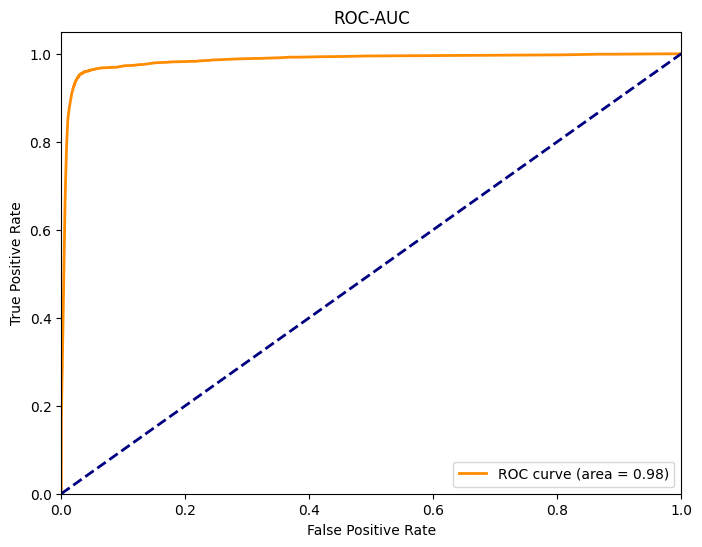

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
y_pred_proba = predictions.predictions.squeeze()
y_true = predictions.label_ids

fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC')
plt.legend(loc="lower right")
plt.show()

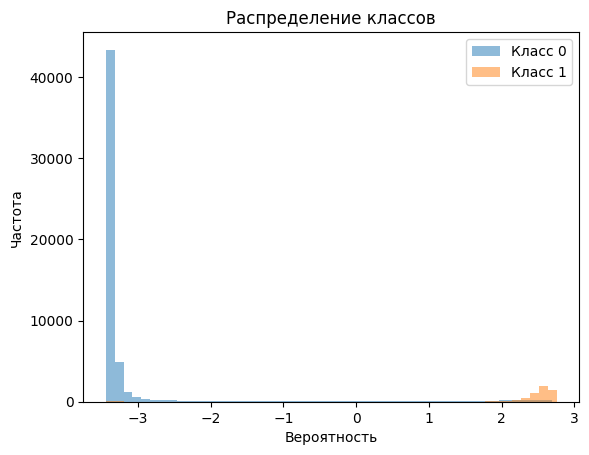

In [15]:
import matplotlib.pyplot as plt


y_pred_proba = predictions.predictions.squeeze()
y_true = predictions.label_ids

class_0_proba = [p for p, t in zip(y_pred_proba, y_true) if t == 0]
class_1_proba = [p for p, t in zip(y_pred_proba, y_true) if t == 1]

plt.hist(class_0_proba, bins=50, alpha=0.5, label='Класс 0')
plt.hist(class_1_proba, bins=50, alpha=0.5, label='Класс 1')
plt.xlabel('Вероятность')
plt.ylabel('Частота')
plt.title('Распределение классов')
plt.legend()
plt.show()

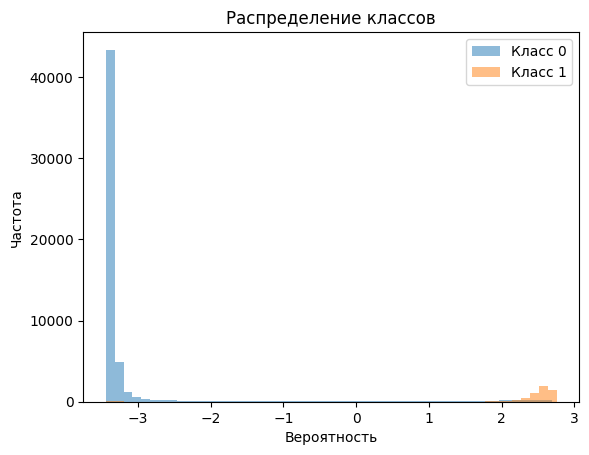

In [16]:
import matplotlib.pyplot as plt

# predictions = trainer.predict(test)

y_pred_proba = predictions.predictions.squeeze()
y_true = predictions.label_ids

class_0_proba = [p for p, t in zip(y_pred_proba, y_true) if t == 0]
class_1_proba = [p for p, t in zip(y_pred_proba, y_true) if t == 1]

plt.hist(class_0_proba, bins=50, alpha=0.5, label='Класс 0')
plt.hist(class_1_proba, bins=50, alpha=0.5, label='Класс 1')
plt.xlabel('Вероятность')
plt.ylabel('Частота')
plt.title('Распределение классов')
plt.legend()
plt.show()